In [1]:
import glob
from skimage.measure import marching_cubes_lewiner, marching_cubes
from sklearn.model_selection import train_test_split
from collections import defaultdict
import nibabel
import os
import trimesh
import numpy as np
from natsort import natsorted
import re
import pymeshlab
sorted = natsorted
from numba import njit
import cc3d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from shutil import rmtree

from tqdm import tqdm_notebook

STEP_SIZE = 20
PROCESS = True
VALIDATE = True
train_on = 'outer'

BRAIN_FOLDER = '../fcd_newdataset/brain_folder/'
MASK_FOLDER = '../fcd_newdataset/mask_folder/'

MESHES_ROOT = f'../fcd_newdataset_meshes_s{STEP_SIZE}_p{int(PROCESS)}_v{int(VALIDATE)}_{train_on}'

SAVE_FOLDER_INNER = os.path.join(MESHES_ROOT,'inner/')
SAVE_FOLDER_OUTER = os.path.join(MESHES_ROOT,'outer/') 
SAVE_FOLDER_INNER_OUTER = os.path.join(MESHES_ROOT,'inner_and_outer/')  

MCNN_TRAINING_ON = {'inner':SAVE_FOLDER_INNER,
                    'outer':SAVE_FOLDER_OUTER,
                    'inner_and_outer':SAVE_FOLDER_INNER_OUTER}[train_on]

REBUILT = False
if REBUILT:
    rmtree(SAVE_FOLDER_INNER)
    rmtree(SAVE_FOLDER_OUTER)
    rmtree(SAVE_FOLDER_INNER_OUTER)
    
for f in [SAVE_FOLDER_INNER, SAVE_FOLDER_OUTER, SAVE_FOLDER_INNER_OUTER]:
    os.makedirs(f, exist_ok=True)
    os.makedirs(os.path.join(f,'seg'), exist_ok=True)
    os.makedirs(os.path.join(f,'sseg'), exist_ok=True)

brain_mask_names = sorted(glob.glob(MASK_FOLDER + '*.nii.gz'))
labels = list(map(lambda x: re.findall('\d+\.\d+',x), brain_mask_names))

brain_img_names = {}
brain_mask_names = {}

for [label] in labels:
    
    brain_path = os.path.join(BRAIN_FOLDER, f'fcd_{label}.nii.gz')
    mask_path = os.path.join(MASK_FOLDER, f'mask_fcd_{label}.nii.gz')
    
    if os.path.isfile(brain_path):
        
        brain_img_names[label] = brain_path
        brain_mask_names[label] = mask_path

In [2]:
# metrics = np.load('metric_dict_epoch.npy', allow_pickle=True).item()
# plt.plot(metrics['train_loss'])
# plt.plot(metrics['val_loss'])
# plt.yscale('log')
# plt.ylable('CE loss')
# plt.xlable('# epoch')
# plt.title('Learning for V2V model')
# plt.show()

# TODO

 - connect falling apart components into one
 - build full w\g-matter graphs

## Util functions

In [3]:
def count_edges(faces):
    """
        input: array of faces
        output: dict, keys = id of edge, value = faces that contains this edge
    """
    edge_dict = {}
    for face in faces:
        keys = [
            tuple(sorted((face[0], face[1]))), tuple(sorted((face[1], face[2]))), tuple(sorted((face[0], face[2])))
        ]
        for key in keys:
            edge_dict[key] = edge_dict.get(key, 0) + 1
    return edge_dict

def get_vertex_labels(verts, mask):
    """
        verts: list of 3d coordinates of vertices
        mask: 3d binary array of mask
        
        labels: binary labels for each vertice
    """
    vs = verts.astype('int32')
    labels = []
    for v_ in vs:
        a, b, c = v_
        labels += [mask[a, b, c]]
    labels = np.array(labels)
    return labels

def get_edge_labels(v_labels, e_dict):
    """
        v_labels: vertex_labels
        e_dict: edge_dict
        
        e_labels: binary labels for each edge
    """
    es = list(e_dict.keys())
    e_labels = []
    for i, (v1, v2) in enumerate(es):
        e_labels += [v_labels[v1] or v_labels[v2]]
    e_labels = np.array(e_labels)
    return e_labels

@njit
def morph_3d(mask, l=5):
    """
        3d dilation for masks
    """
    d, h, w = mask.shape
    mask_padded = np.zeros((d+2*l//2, h+2*l//2, w+2*l//2))
    mask_padded[l//2: -l//2, l//2: -l//2, l//2: -l//2] = mask.copy()
    for i in range(d):
        for j in range(h):
            for k in range(w):
                mask[i, j, k] = np.all(mask_padded[i: i + l, j: j + l, k: k + l])
                
def show_slices(brain_tensor, n_slices_show=5, mask_tensor=None):
    
    fig, axes = plt.subplots(ncols=3, nrows=n_slices_show, figsize=(15,n_slices_show*5))
    X_max, Y_max, Z_max = brain_tensor.shape
    for i in range(n_slices_show):

        x_slice_pos = (X_max//(n_slices_show+2))*(i+1)
        y_slice_pos = (Y_max//(n_slices_show+2))*(i+1)
        z_slice_pos = (Z_max//(n_slices_show+2))*(i+1)

        brain_tensor_x_slice = brain_tensor[x_slice_pos,:,:]
        brain_tensor_y_slice = brain_tensor[:,y_slice_pos,:]
        brain_tensor_z_slice = brain_tensor[:,:,z_slice_pos]

        axes[i,0].imshow(brain_tensor_x_slice, 'gray')
        axes[i,1].imshow(brain_tensor_y_slice, 'gray')
        axes[i,2].imshow(brain_tensor_z_slice, 'gray')
        
        if mask_tensor is not None:
            
            mask_tensor_x_slice = mask_tensor[x_slice_pos,:,:]
            mask_tensor_y_slice = mask_tensor[:,y_slice_pos,:]
            mask_tensor_z_slice = mask_tensor[:,:,z_slice_pos]

            axes[i,0].imshow(mask_tensor_x_slice, 'jet', interpolation='none', alpha=0.7)
            axes[i,1].imshow(mask_tensor_y_slice, 'jet', interpolation='none', alpha=0.7)
            axes[i,2].imshow(mask_tensor_z_slice, 'jet', interpolation='none', alpha=0.7)
    plt.tight_layout()
    plt.show()

##  Extracting example

In [4]:
# label = '10.1'
# br_name = brain_img_names[label]

# brain = nibabel.load(br_name)
# mask = nibabel.load(brain_mask_names[label]).get_fdata() > 0 # why cast to bool? 
# brain_tensor_orig = brain.get_fdata() 

In [5]:
# plt.hist(brain_tensor_orig[brain_tensor_orig>0].flatten(), bins=100, label='pixel intensity hist')
# white_matter_threshold = np.percentile(brain_tensor_orig[brain_tensor_orig>0].flatten(), 50)
# plt.vlines(white_matter_threshold, 0, 400000, linestyle='--', color='red', label='median')
# plt.legend()
# plt.show()

In [6]:
# show_slices(brain_tensor_orig, n_slices_show=3, mask_tensor=None)

In [7]:
# show_slices(brain_tensor_orig, n_slices_show=2, mask_tensor=brain_tensor_orig > white_matter_thresold)

In [8]:
# brain_tensor_white = brain_tensor_orig > white_matter_threshold # for the inner
# l = 1
# t = 0.4
# brain_tensor_white = gaussian_filter(brain_tensor_white.astype('float'), sigma=l)
# brain_tensor_white = brain_tensor_white > t # gray matter vs white matter? 
# labels_in = brain_tensor_white # where is a white matter

In [9]:
# show_slices(brain_tensor_orig, n_slices_show=3, mask_tensor=labels_in)

In [10]:
# labels_out = cc3d.connected_components(labels_in, connectivity=6)
# u, c = np.unique(labels_out, return_counts=True)
# max_connected_label = np.argmax(c[1:]) + 1
# brain_tensor_white = labels_out == max_connected_label

In [11]:
# show_slices(brain_tensor_orig, n_slices_show=3, mask_tensor=brain_tensor_white)

In [12]:

# verts, faces, normals, values = marching_cubes(brain_tensor_white, 
#                                                step_size=40, # 6
#                                                allow_degenerate=False, 
#                                                gradient_direction='ascent')

In [13]:
# mesh_n = trimesh.base.Trimesh(vertices = verts, faces = faces, vertex_normals=normals, process = True, validate=True)
# # mesh_n.export("example_mesh.obj")

In [14]:
# mesh_n.show(smooth=True)

In [15]:
# with open('example_mesh.obj') as file:
#     data = file.read()

In [16]:
# data = data.split('\n')[1:]
# types = []
# for obj in tqdm_notebook(data):
#     s = obj[:2].strip()
#     if s not in types:
#         types.append(s)

# Extracting all meshes

In [17]:
for mesh_type,SAVE_FOLDER in {'inner':SAVE_FOLDER_INNER, 
                              'outer':SAVE_FOLDER_OUTER}.items():
    
    for i, (label,br_name) in tqdm_notebook(enumerate(brain_img_names.items())):

        brain_tensor = nibabel.load(br_name).get_fdata() 
        mask_tensor = nibabel.load(brain_mask_names[label]).get_fdata() > 0
        white_matter_threshold = np.percentile(brain_tensor[brain_tensor>0].flatten(), 50)
        if mesh_type == 'inner':
            brain_tensor = brain_tensor > white_matter_threshold
            l = 1
            t = 0.4
            brain_tensor = gaussian_filter(brain_tensor.astype('float'), sigma=l)
            brain_tensor = brain_tensor > 0.4 # gray matter vs white matter? 
            labels_in = brain_tensor

            labels_out = cc3d.connected_components(labels_in, connectivity=6)
            u, c = np.unique(labels_out, return_counts=True)
            max_connected_label = np.argmax(c[1:]) + 1
            brain_tensor = labels_out == max_connected_label

        else:
            brain_tensor = brain_tensor > 0

        verts, faces, normals, values = marching_cubes(brain_tensor, 
                                                       step_size=STEP_SIZE, 
                                                       allow_degenerate=False, 
                                                       gradient_direction = 'ascent')
        
        v_labels = get_vertex_labels(verts, mask_tensor)
        print('vertex labels mean', v_labels.mean())
        
        e_dict = count_edges(faces)
        np_e_dict = np.array(list(e_dict.values()))
        e_labels = get_edge_labels(v_labels, e_dict)
        print('edge labels mean', v_labels.mean())

        print('number of manifold edges', (np_e_dict == 2).sum())
        print('number of non-manifold edges', (np_e_dict != 2).sum())

        mesh_n = trimesh.base.Trimesh(vertices = verts, faces = faces, process = PROCESS, validate=VALIDATE)
        mesh_n.export(os.path.join(SAVE_FOLDER, f"{label}.obj")) # 'v', 'vn', 'f'
 
        seg = e_labels + 1 # WHAT IS A FUCKING POINT? (see self.classes, self.offset in SegmentationData)
        sseg = np.zeros((len(e_dict), 2), dtype=np.int32)
        sseg[np.arange(seg.size), seg-1] = 1

        with open(os.path.join(SAVE_FOLDER, f"{label}.obj"), 'a') as f:
            for j, e in enumerate(e_dict):
                f.write(f'\ne {e[0]} {e[1]} {seg[j]}') # why add edges?
        
        # remove first line with trimesh github link
        with open(os.path.join(SAVE_FOLDER, f"{label}.obj"), 'r') as fin:
            data = fin.read().splitlines(True)
        with open(os.path.join(SAVE_FOLDER, f"{label}.obj"), 'w') as fout:
            fout.writelines(data[1:]) 
        
        # save labels
        np.savetxt(os.path.join(SAVE_FOLDER, f'seg/{label}.eseg'), seg)
        np.savetxt(os.path.join(SAVE_FOLDER, f'sseg/{label}.seseg'), sseg)

/hdd/ibulygin/miniconda3/envs/fcd_hpc2/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

vertex labels mean 0.0018039687312086591
edge labels mean 0.0018039687312086591
number of manifold edges 5337
number of non-manifold edges 0
vertex labels mean 0.003161222339304531
edge labels mean 0.003161222339304531
number of manifold edges 5952
number of non-manifold edges 0
vertex labels mean 0.004029936672423719
edge labels mean 0.004029936672423719
number of manifold edges 5439
number of non-manifold edges 0
vertex labels mean 0.0031729243786356425
edge labels mean 0.0031729243786356425
number of manifold edges 6075
number of non-manifold edges 15
vertex labels mean 0.002890173410404624
edge labels mean 0.002890173410404624
number of manifold edges 5496
number of non-manifold edges 0
vertex labels mean 0.009375
edge labels mean 0.009375
number of manifold edges 6144
number of non-manifold edges 9
vertex labels mean 0.005288207297726071
edge labels mean 0.005288207297726071
number of manifold edges 5967
number of non-manifold edges 9
vertex labels mean 0.0023752969121140144
edge 

0it [00:00, ?it/s]

vertex labels mean 0.004537205081669692
edge labels mean 0.004537205081669692
number of manifold edges 3300
number of non-manifold edges 0
vertex labels mean 0.0
edge labels mean 0.0
number of manifold edges 3624
number of non-manifold edges 0
vertex labels mean 0.0
edge labels mean 0.0
number of manifold edges 3516
number of non-manifold edges 0
vertex labels mean 0.008620689655172414
edge labels mean 0.008620689655172414
number of manifold edges 3474
number of non-manifold edges 0
vertex labels mean 0.0
edge labels mean 0.0
number of manifold edges 3405
number of non-manifold edges 0
vertex labels mean 0.0
edge labels mean 0.0
number of manifold edges 3330
number of non-manifold edges 0
vertex labels mean 0.004934210526315789
edge labels mean 0.004934210526315789
number of manifold edges 3642
number of non-manifold edges 0
vertex labels mean 0.0
edge labels mean 0.0
number of manifold edges 3339
number of non-manifold edges 18
vertex labels mean 0.0
edge labels mean 0.0
number of man

##  Combining inner and outter meshes

In [18]:
def count_vertices(data):
    """
        return count of vertices, faces and edges
    """
    for j in range(len(data)):
        if data[j][0] != 'v':
            a = j
            break
    for j in range(a, len(data)):
        if data[j][0] != 'f':
            b = j
            break
    return a, b - a, len(data) - b

def shift_line(line, n):
    """
        line: line from text description of .obj file. it starts with 'v', 'e' or 'f'
        n: shift indexing by this number
        
        return: shifted line
    """
    ls = line.split(' ')
    joins = [ls[0], str(int(ls[1]) + n), str(int(ls[2]) + n)]
    try:
        if ls[0] == 'e':
            joins.append(str(int(ls[3])))
        else:
            joins.append(str(int(ls[3]) + n))
    except:
        print(line)
        print(ls)
        raise ValueError
    return " ".join(joins) + '\n'

In [19]:
# label = '0.1'
# with open(os.path.join(SAVE_FOLDER_INNER, f"{label}.obj"), 'r') as fin:
#     data_inner = fin.read().splitlines(True)
        
# with open(os.path.join(SAVE_FOLDER_OUTER, f"{label}.obj"), 'r') as fin:
#     data_outter = fin.read().splitlines(True)

In [20]:
if MCNN_TRAINING_ON == SAVE_FOLDER_INNER_OUTER:
    for label in tqdm_notebook(brain_img_names.keys()):

        with open(os.path.join(SAVE_FOLDER_INNER, f"{label}.obj"), 'r') as fin:
            data_inner = fin.read().splitlines(True)

        with open(os.path.join(SAVE_FOLDER_OUTER, f"{label}.obj"), 'r') as fin:
            data_outter = fin.read().splitlines(True)

        a1, b1, c1 = count_vertices(data_inner) # vertices, faces and edges
        a2, b2, c2 = count_vertices(data_outter) 

        data = []

        # vertices
        data += data_inner[:a1] # inner vertices
        data += data_outter[:a2] # inner + outer vertices

        # faces
        data += data_inner[a1: a1 + b1] # inner + outer vertices + inner faces
        data += list(map(lambda x: shift_line(x, a1), data_outter[a2: a2 + b2])) # (inner + outer vertices) + (inner + outer faces)

        # edges
        data += data_inner[a1 + b1:]
        data += list(map(lambda x: shift_line(x, a1), data_outter[a2 + b2:]))

        with open(SAVE_FOLDER_INNER_OUTER + f"{label}.obj", 'w') as fout:
            fout.writelines(data)

        seg_inner = np.loadtxt(os.path.join(SAVE_FOLDER_INNER, 'seg/' + f"{label}.eseg"))
        sseg_inner = np.loadtxt(os.path.join(SAVE_FOLDER_INNER, 'sseg/' + f"{label}.seseg"))    

        seg_outter = np.loadtxt(os.path.join(SAVE_FOLDER_OUTER,'seg/' + f"{label}.eseg"))
        sseg_outter = np.loadtxt(os.path.join(SAVE_FOLDER_OUTER,'sseg/' + f"{label}.seseg"))

        seg = np.concatenate([seg_inner, seg_outter])
        sseg = np.concatenate([sseg_inner, sseg_outter])
        print(i, c1 + c2, seg.mean() - 1)

        np.savetxt(os.path.join(SAVE_FOLDER_INNER_OUTER, f'seg/{label}.eseg'), seg)
        np.savetxt(os.path.join(SAVE_FOLDER_INNER_OUTER, f'sseg/{label}.seseg'), sseg)

## Preparing data for training MeshCNN

In [21]:
import shutil

FCD_FOLDER = os.path.join(MESHES_ROOT,'prepared/')

labels_all = list(brain_img_names.keys())
train_labels, test_labels = train_test_split(labels_all)

os.makedirs(os.path.join(FCD_FOLDER, 'train'), exist_ok=True)
os.makedirs(os.path.join(FCD_FOLDER, 'test'), exist_ok=True)
os.makedirs(os.path.join(FCD_FOLDER, 'seg'), exist_ok=True)
os.makedirs(os.path.join(FCD_FOLDER, 'sseg'), exist_ok=True)

if os.path.exists(FCD_FOLDER +'test/cache'):
    shutil.rmtree(FCD_FOLDER + 'test/cache')
if os.path.exists(FCD_FOLDER + 'train/cache'):
    shutil.rmtree(FCD_FOLDER + 'train/cache')
    
files = glob.glob(FCD_FOLDER + 'test/*')
for f in files:
    os.remove(f)
files = glob.glob(FCD_FOLDER + 'train/*')
for f in files:
    os.remove(f)


for label in train_labels:
    shutil.copyfile(MCNN_TRAINING_ON + f"{label}.obj", FCD_FOLDER + 'train/' + f"{label}.obj")
    shutil.copyfile(MCNN_TRAINING_ON + 'seg/'+ f"{label}.eseg", FCD_FOLDER + 'seg/' + f"{label}.eseg")
    shutil.copyfile(MCNN_TRAINING_ON + 'sseg/'+ f"{label}.seseg", FCD_FOLDER + 'sseg/' + f"{label}.seseg")

for label in test_labels:
    shutil.copyfile(MCNN_TRAINING_ON + f"{label}.obj", FCD_FOLDER + 'test/' + f"{label}.obj")
    shutil.copyfile(MCNN_TRAINING_ON + 'seg/'+ f"{label}.eseg", FCD_FOLDER + 'seg/' + f"{label}.eseg")
    shutil.copyfile(MCNN_TRAINING_ON + 'sseg/'+ f"{label}.seseg", FCD_FOLDER + 'sseg/' + f"{label}.seseg")   

In [22]:
FCD_FOLDER

'../fcd_newdataset_meshes_s20_p1_v1_outer/prepared/'

In [23]:
meshes_statistics = defaultdict(list)
for label in tqdm_notebook(labels_all):
    mesh_statistics = defaultdict(int)
    with open(os.path.join(MCNN_TRAINING_ON, f"{label}.obj"), 'r') as fin:
        print(label)
        data_io = fin.read().splitlines(True)
        for d in data_io:
            mesh_statistics[d.split(' ')[0]] += 1
    
    for k,v in mesh_statistics.items():
        meshes_statistics[k].append(v)

/hdd/ibulygin/miniconda3/envs/fcd_hpc2/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/27 [00:00<?, ?it/s]

0.1
1.1
2.1
3.1
4.1
5.1
6.1
7.1
8.1
9.1
10.1
11.1
12.1
13.1
14.1
15.1
16.1
17.1
18.1
19.1
20.1
21.1
22.1
23.1
24.1
25.1
26.1


In [24]:
max(meshes_statistics['e'])

3905

In [25]:
ls -la ../ | grep fcd

drwxr-xr-x  4 ibulygin users     4096 сен 11 18:15 fcd_newdataset/
drwxr-xr-x  6 ibulygin users     4096 сен 21 12:17 fcd_newdataset_meshes_s10_p1_v1_outer/
drwxr-xr-x  6 ibulygin users     4096 сен 21 11:24 fcd_newdataset_meshes_s20_p1_v1_outer/
drwxr-xr-x  4 ibulygin users     4096 сен 20 17:41 fcd_newdataset_tensors/


## Shifting meshes from FreeSurfer

In [26]:
# N = 15
# base_names = ['lh.pial', 'lh.orig', 'rh.pial', 'rh.orig']
# def shift_mesh(i, base_name):
#     coords, faces, meta = nibabel.freesurfer.io.read_geometry(f'{i}_1_surf/{base_name}', read_metadata=True)
#     coords += meta['cras']
#     m = pymeshlab.Mesh(coords, faces)
#     ms = pymeshlab.MeshSet()
#     ms.add_mesh(m, base_name)
#     ms.save_current_mesh(f"meshlab_objects/{i}_{base_name}.obj")

# for i in range(N):
#     for base_name in base_names:
#         shift_mesh(i, base_name)

## Checking good value for gauss sigma and threshold value

In [27]:

# for i, br_name in enumerate(brain_img_names):
#     print(i)
#     brain = nibabel.load(br_name)
#     mask = nibabel.load(brain_mask_names[i]).get_fdata() > 0
#     brain_tensor = brain.get_fdata() > 95
#     l = 7
#     brain_tensor = gaussian_filter(brain_tensor.astype('float'), sigma=l)
#     nifti = nibabel.Nifti1Image(brain_tensor.astype('float'), brain.affine)
#     nibabel.save(nifti, f"{i}_gauss_g_{l}.nii.gz")
#     t = 0.4
#     nifti_t = nibabel.Nifti1Image((brain_tensor > t).astype('float'), brain.affine)
#     nibabel.save(nifti_t, f"{i}_gauss_g_{l}_t_{t}.nii.gz") 

In [29]:
metrics = np.load('metric_dict_epoch.npy', allow_pickle=True).item()

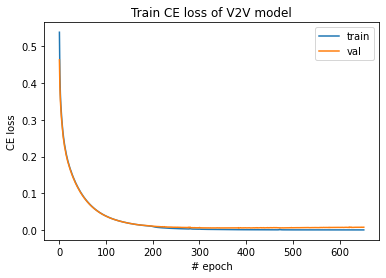

In [32]:
plt.plot(metrics['train_loss'], label='train')
plt.plot(metrics['val_loss'], label='val')
plt.title('Train CE loss of V2V model')
plt.xlabel('# epoch')
plt.ylabel('CE loss')
plt.legend()
plt.show()